# セマンティックセグメンテーション(PSPNet)

In [4]:
!gpustat

s2                   Thu Apr 30 11:47:03 2020  440.44
[0] Quadro RTX 8000  | 56'C,  67 % | 19431 / 48601 MB | inoue(19419M)
[1] Quadro RTX 8000  | 26'C,   0 % |   889 / 48601 MB | hisadome(877M)
[2] Quadro RTX 8000  | 33'C,   0 % |     0 / 48601 MB |
[3] Quadro RTX 8000  | 56'C, 100 % | 24357 / 48601 MB | inoue(24345M)
[4] Quadro RTX 8000  | 22'C,   0 % |     0 / 48601 MB |
[5] Quadro RTX 8000  | 52'C,  99 % | 24235 / 48601 MB | taoli(24157M)
[6] Quadro RTX 8000  | 61'C, 100 % | 33237 / 48601 MB | hara(33225M)
[7] Quadro RTX 8000  | 48'C,  10 % |  9791 / 48601 MB | taoli(9745M)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms


# パッケージのimport
import os.path as osp
from PIL import Image



# 実装したネットワークで出力
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = "cpu"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 3-1 セマンティックセグメンテーションとは
本章では画像処理タスクの１つである，セマンティックセグメンテーションに取り組みながら**PSPNet(Pyramid Scene Parsing Network)**と呼ばれるモデルについて理解する．

### セマンティックセグメンテーションの入出力
セマンティックでの入出力の関係は
- input : 画像
- output : 各ピクセルが所属するクラスのラベル情報

出力については**カラーパレット形式**よって表現し，それぞれのラベルに対して予め固有のRGBの値を付与しておきそのRGBの値を元に図示する.

### VOCデータセット
ここではVOCデータセットを用いるが，その中でもセマンティックセグメンテーション用にアノテーションが用意されている画像データのみを使用する．訓練データ1,464枚と検証データ1,449枚を用いる．

### PSPNetによる物体検出の流れ
**PSPNet(Pyramid Scene Parsing Network)** とはセマンティックセグメンテーションを行うディープラーニングアルゴリズムの一種である．

PSPNetは大きく４つのステップによって構成される．
1. 前処理を行う．具体的には画像サイズのリサイズと色情報の標準化を行う.
2. PSPNetに対して前処理した画像を入力する(H,W)．すると出力として(C+1, H, W)のサイズを持つ出力を得る．C+1は背景を加えたクラスの数を表している．この出力は各ピクセルに対するそれぞれのクラスの確信度を表す．
3. PSPNetの出力に対して，各ピクセルのクラス予測確信度が最大のものをそのピクセルのクラスと予測する．
4. 3の処理を終えた(H, W)のサイズの画像を元の画像サイズにリサイズし直して出力する．

## 3-2 DatasetとDataLoaderの実装

### 画像データ，アノテーションデータへのファイルパスのリストを作成

In [7]:
def make_datapath_list(rootpath):
    
    
    # テンプレート この%sにあとでいろいろ入れる
    imgpath_template = osp.join(rootpath, "JPEGImages", "%s.jpg")
    annopath_template = osp.join(rootpath, "SegmentationClass", "%s.png")
    
    # 訓練と検証，　それぞれのファイルIDを取得
    train_id_names = osp.join(rootpath + "ImageSets/Segmentation/train.txt")
    val_id_names = osp.join(rootpath + "ImageSets/Segmentation/val.txt")
    
    # 訓練データの画像ファイルとアノテーションファイルへのパスリスト
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
        
    # 検証データの画像ファイルとアノテーションファイルへのパスリスト
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
        
    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [8]:
# 動作確認
roopath = "data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(roopath)
print(train_img_list[0])
print(train_anno_list[0])

data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


### Datasetの作成
まずDataTransformを実装する．このDataTransformの詳しい内容については省略し，前処理クラスのインポートを行うことにとどめる．

1. まず対象画像とアノテーションデータをセットに対してセットで前処理を行う必要があるのでこれらをセットで変換することを可能にする```Compose```を用意する．
2. 次にこの```Compose```クラス内で種々の前処理を行うことによってモデルの汎化性能を高める．ここで行う前処理はリサイズ・切り取り・回転・色情報の標準化などがある．

セグメンテーション用のアノテーションデータには，物体の境界部分にはラベル255が特別についているのでこれは背景を表すラベル０に吸収させる．物体検出では背景に元々ラベルが与えられたなかったので全体のインデックスをインクリメントする必要があったがセグメンテーション用のアノテーションではそのようなことをする必要はない．

- ```RandomMirror()```確率1/2で左右を反転させる


In [9]:
# class DataTransformを定義する．
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor


class DataTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ])
        }
        
    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


次にDatasetを実装する．本章では画像の読み込みにOpenCVではなくPillow(PIL)利用する．そのために色情報の並びはRGBになる．

In [10]:
class VOCDataset(data.Dataset):
    
    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        """
        前処理した画像のTensor形式のデータとアノテーションを取得
        """
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        """
        画像のTensor形式のデータ，アノテーションを取得する
        """
        
        # 1. 画像の読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path) # [H][W][RGB]
        
        # 2. アノテーション画像の読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)  # [H][W]
        
        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)
        
        return img, anno_class_img

In [11]:
# 動作確認

# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# # データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
# print(val_dataset.__getitem__(0)[1].shap/

torch.Size([3, 475, 475])


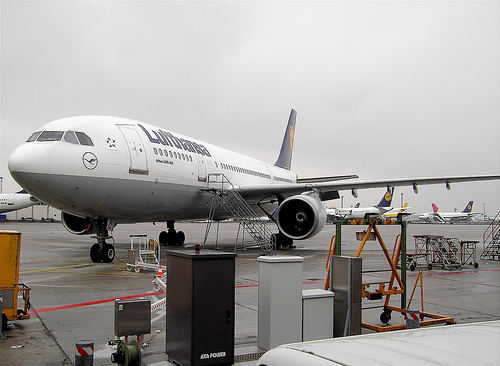

In [12]:
Image.open(val_dataset.img_list[0]) 

In [13]:

batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475]

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


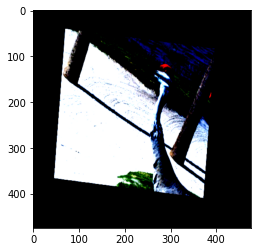

56
data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
data/VOCdevkit/VOC2012/SegmentationClass/2007_000039.png


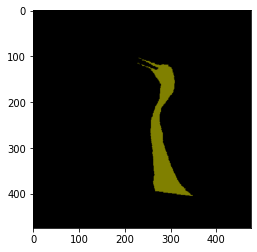

In [14]:
# 実行するたびに変わります

# 画像データの読み込み
index = 3
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
print(len(train_anno_list[0]))
print(train_anno_list[0])
print(train_anno_list[1])
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


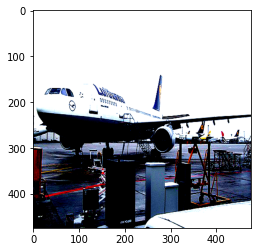

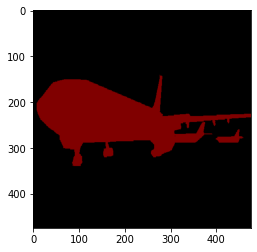

In [15]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

## 3-3 PSPNetのネットワーク構成と実装
本節ではPSPNetの構成をモジュール単位で理解する．

### PSPNetを構成するモジュール
PSPNetは大きく４つのモジュールによって構成されている．
1. Feature
2. Pyramid Pooling
3. Decoder
4. AuxLoss

---

***Feature:***  

Encoderモジュールとも言う．このモジュールの目的は入力画像の特徴を捉えることである．
$$
(batchsize, 3, H, W) \rightarrow (batchsize, 2048, 60, 60)
$$
画像の特徴を捉えたチャネルを2048チャネル用意し，画像サイズを入力よりも小さくしている点に注意する．

---
***Pyramid Pooling:***

このプーリング層がPSPNetの特徴である．Pyramid Poolingで解決する問題は**あるピクセルの物体ラベルを求めるにはそのピクセルの周辺のみではなくより高域な画像の情報も含めた情報を必要とする**という問題である．そこでPyramid Poolingでは様々なサイズの特徴量マップを用意する．
$$
(batchsize, 2048, 60, 60) \rightarrow (batchsize, 4096, 60, 60)
$$

---

***Decoder:***

Pyramid Pooling 層の出力から各ピクセルの確信度を出力する．
$$
(batchsize, 4096, 60, 60) \rightarrow (batchsize, 21, H, W)
$$

---

***AuxLoss:***

```Aux = auxiliary(補助の)```　本来であれば上の３つのモジュールのみでセグメンテーション自体は可能であるがさらに結合パラメータの学習をよく行うためにAuxLossを用いる．Featureモジュールからテンソルを抜き出して，これをDecoderの主力と同じサイズにする．
$$
(batchsize, 1024, 60, 60) \rightarrow (batchsize, 21, H, W)
$$
**Featureの途中から抜き出しているので入力がPyramid Poolingと異なることに注意**

---
学習時にはAuxLossを用いるが推論時にはDecoderのみを用いてセグメンテーションを行う．AuxLossを用いて学習をすると確かに精度としては低いが，バックプロパゲーションによる更新が直接Feature層に届くのでFeature層のモデルが良くなることを補助することができる．



### PSPNetクラスの実装
それぞれのサブネットワークの中身は以降で実装していく．
```ResidualBlockPSP```には```mid_channels```が存在する

In [16]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に

        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2) # ここの出力(1024, 60, 60)をauxに
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)

## 3-4 Featureモジュールの解説と実装(ResNet)
Featureモジュールを構成するサブネットワークの構成を理解して実装する．

### Featureモジュールのサブネットワーク構成
Featureモジュールのサブネットワークは５つから構成される．
1. FeatureMap_convolution
2. ResidualBlockSPS
3. ResidualBlockSPS
4. ResidualBlockSPS(dilated version)→AuxLoss モジュールへ
5. ResidualBlockSPS(dilated version)

dilated：拡張した
Convolutionでdilationが用いられているので視覚的にわかりやすい動画→https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

### FeatureMap_convolution

**Conv+BN+ReLU**を３つ通過した後に**Max_Pooling**を行う．**Conv+BN+ReLU**の部分を```conv2DBatchNormRelu```としてモジュール化して実装する．

Featureモジュールの中のFeatureMap_convolutionモジュールの中のConv+BN+ReLUの部分をモジュール化することによって実装をラクにする．このモジュール化するときに```nn.Module```を継承してモジュール化を行うので```forward```だけ実装すれば良い

In [17]:
# FeatureMap_convolution　の実装
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)
        
        return outputs

In [18]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False  # めちゃくちゃハードコーディング
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs

### ResidualBlockPSP
**residual：残りの**

ResidualBlockPSPは以下の２つの工程によって構成される．それぞれの違いはスキップ結合における処理にある．
1. bottleNeckPSP:スキップ結合部分にconv2D
2. bottleNeckIdentifyPSP(何回か繰り返される)：スキップ結合部分では何も行わない

Featureモジュールの後半ではResidualBlockPSPではそれぞれのbottleNeckIdentifyPSPの層数が異なる．


**また以下のResidualPSPには```forward```がないのは```nn.Sequential```を継承しているからである．```nn.Module```を継承する場合には```forward```を実装する必要があったが```nn.Sequential```を継承する場合にはその必要はない．**

In [24]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )

In [25]:
residualnet = ResidualBlockPSP(3,64,128,256,2,1)
print(residualnet.block1)
residualnet

bottleNeckPSP(
  (cbr_1): conv2DBatchNormRelu(
    (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cbr_2): conv2DBatchNormRelu(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cb_3): conv2DBatchNorm(
    (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_residual): conv2DBatchNorm(
    (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)


ResidualBlockPSP(
  (block1): bottleNeckPSP(
    (cbr_1): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbr_2): conv2DBatchNormRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cb_3): conv2DBatchNorm(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cb_residual): conv2DBatchNorm(
      (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (r

### bottleNeckPSPとbottleNeckIdentifyPSP
そもそも```ResidualBlock```や```bottleNeck```自体は***ResNet***と呼ばれるネットワークで利用されていたがそれをPSPNetに転用しているのでPSPと言う名前が後置されている．
層が深くなることによって起こる劣化問題をスキップ結合を作ることによって回避しようとしている．

bottleNeckPSPモジュールとbottleNeckIdentifyPSPモジュールの実装

In [21]:
#bottleNeckPSPにもbottleNeckIdentifyPSPにもConv+BNが何回も出てくるので先にモジュール化しておく
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs

In [22]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        
        # 本筋の最後の１つはReLUがないので注意→スキップ結合と合わせてから一緒にReLUに入れる
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual) #　最後は２つを合わせてからReLUに入れる

In [23]:
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)

## 3-5 Pyramid Poolingモジュールの解説と実装

### Pyramid Poolingモジュールのサブネットワーク構造

***Adaptive Average Pooling：***出力サイズを指定することができるAverage Pooling<br>
***UpSample：***画像サイズを拡大する.拡大時の補完方法は**bilinear処理**を使用する

Pyramid Pooling層ではまずFeature層から来た入力を５つに分ける（コピーする）．このうちの４つはそれぞれ**Adaptive Average Pooling**に入力する．<br>そのAdaptive Average Poolingからの出力を```conv2DBatchNormRelu```に入力する．その後にUpSmaple層に入力してAdaptive Average Poolingによって小さくなった画像サイズを元々のサイズに戻す．<br>結果としてこの４つの特徴量マップは$(512,60,60)$のサイズになる．<br>
Adaptive Average Poolingに入力されなかったものはスキップ結合をされる．

結果としてPyramid Poolingモジュールは以下の入力と出力のサイズを持つ.<br>この$4096$は$(512\times4 + 2048)$から計算される
$$
(minibatch, 2048, 60, 60) \rightarrow (minibatch, 4096, 60, 60)
$$

```out_channels = int(in_channels / len(pool_sizes))``` より，スキップ結合とAdaptive Poolingから来た出力を1:1にしている

### Pyramid Poolingクラスの実装

In [26]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)


        return output

パラメータをロードする際に以下のコードを実行すると想定されているネットワークと名前が異なるので実行することができない．

In [27]:
# class PyramidPooling(nn.Module):
#     def __init__(self, in_channels, pool_sizes, height, width):
#         super(PyramidPooling, self).__init__()

#         # 最後に入力サイズに戻すのでここに補完しておく
#         self.height = height
#         self.width = width

#         # 各畳み込み層の出力チャネル数
#         out_channels = int(in_channels / len(pool_sizes)) #　スキップ結合との比を保つ

#         # 各畳み込み層を作成
#         # pool_sizes: [6, 3, 2, 1]
#         self.avpool_n = list()
#         for i in range(len(pool_sizes)):
#             self.avpool_n.append(nn.AdaptiveAvgPool2d(output_size=pool_sizes[i]))
            
#         self.cbr = conv2DBatchNormRelu(
#             in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
            

#     def forward(self, x):
#         output = x
        
#         out_list = list()
#         for i in range(len(self.avpool_n)):
#             out = self.avpool_n[i](x)
#             out = self.cbr(out)
#             out = F.interpolate(out, size=(self.height, self.width), mode="bilinear", align_corners=True)

#             output = torch.cat([output,out], dim = 1)
        

#         return output

## 3-6 Decoder, AuxLossモジュールの解説と実装

### DecoderおよびAuxLossモジュールの構造
- Decoder：
$(batch, 4096, 60, 60) \rightarrow (batch, 21, 475, 475)$
<br>
- AuxLoss:
$(batch, 1024, 60, 60) \rightarrow (batch, 21, 475, 475)$

それぞれ入力されたチャネルを21チャネルに減らして，画像サイズを元の入力サイズまで大きくする．

最後それぞれのチャネルを21チャネルに変更する点はAffineではなくConv2d(pointwise convolution)によって変更を行っている

### DecoderおよびAuxLossモジュールの実装

In [28]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [29]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [30]:
# モデルの動作確認
net = PSPNet(n_classes=21)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [31]:
batch_size = 2
dummy_img = torch.randn(batch_size, 3, 475, 475)
output = net(dummy_img)
print(output[0].shape)
print(output[1].shape)

torch.Size([2, 21, 475, 475])
torch.Size([2, 21, 475, 475])


## 3-7 ファインチューニングによる学習と検証の実施

### 学習・検証の実装
先ほど実装した```DataTransform```を用いる```Dataset```を```DataLoader```にセットする．<br>
```DataLoader```は```torch.utils.data```のものを使う

In [32]:
# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

### ネットワークの初期化
今回のPSPNetは元論文では150クラスを分類するセマンティックだったので，今回はその150クラスを分類するネットワークモデルの訓練済みパラメータからファインチューンングを行う．<br>この時に今作っているネットワークのクラスは21クラスなのでこの部分のネットワークを付け替える

In [33]:
# まずはパラメータをロードしたいので150クラスで作る
net = PSPNet(n_classes=150)

state_dict = torch.load("./weights/pspnet50_ADE20K.pth")
print(net.load_state_dict(state_dict))


# ここから最後のそうだけ付け替える (pointwise convolution の部分を変えれば良い)
n_classes = 21
load_epoch = 0
net.decode_feature.classification = nn.Conv2d(in_channels=512,
                                             out_channels=n_classes, kernel_size=1, stride=1, padding=0)
net.aux.classification = nn.Conv2d(in_channels=216,
                                             out_channels=n_classes, kernel_size=1, stride=1, padding=0)

def weighs_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weighs_init)
net.aux.classification.apply(weighs_init)

print("ネットワークの初期化完了")

<All keys matched successfully>
ネットワークの初期化完了


In [35]:
# 学習ずみデータを用いる場合
net = PSPNet(n_classes=21)
load_epoch =20
state_dict = torch.load("./weights/pspnet50_"+str(load_epoch)+".pth")
print(net.load_state_dict(state_dict))
print("学習済みモデルをロード完了")

<All keys matched successfully>
学習済みモデルをロード完了


### 損失関数の定義
クロスエントロピーを利用する．この時にメインのLossに対してAuxのLossには0.4を掛ける．
$$
loss = loss_{main}+ 0.4 \cdot loss_{Aux}
$$

In [36]:
# 損失関数の設定
class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 4755]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux


criterion = PSPLoss(aux_weight=0.4)

### スケジューラーを利用したepochごとの学習率の変更

In [37]:
# ファインチューニングなので、学習率は小さく
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)


# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [38]:
# モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は5回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/pspnet50_' +
               str(epoch+1+load_epoch) + '.pth')

In [42]:
# 学習・検証を実行する
num_epochs = 10
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/10
-------------
（train）


/home/hasegawa/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


イテレーション 10 || Loss: 0.2718 || 10iter: 37.8288 sec.
イテレーション 20 || Loss: 0.3738 || 10iter: 18.6425 sec.
イテレーション 30 || Loss: 0.2584 || 10iter: 17.7694 sec.
イテレーション 40 || Loss: 0.1986 || 10iter: 17.1300 sec.
イテレーション 50 || Loss: 0.1465 || 10iter: 18.3252 sec.
イテレーション 60 || Loss: 0.1817 || 10iter: 19.1394 sec.
イテレーション 70 || Loss: 0.1919 || 10iter: 18.5339 sec.
イテレーション 80 || Loss: 0.1037 || 10iter: 18.4570 sec.
イテレーション 90 || Loss: 0.1555 || 10iter: 18.6799 sec.
イテレーション 100 || Loss: 0.1721 || 10iter: 19.4738 sec.
イテレーション 110 || Loss: 0.1505 || 10iter: 14.4633 sec.
イテレーション 120 || Loss: 0.0683 || 10iter: 12.9832 sec.
イテレーション 130 || Loss: 0.1204 || 10iter: 14.2910 sec.
イテレーション 140 || Loss: 0.1433 || 10iter: 14.6625 sec.
イテレーション 150 || Loss: 0.0777 || 10iter: 23.2556 sec.
イテレーション 160 || Loss: 0.1220 || 10iter: 23.3441 sec.
イテレーション 170 || Loss: 0.0798 || 10iter: 22.1811 sec.
イテレーション 180 || Loss: 0.1282 || 10iter: 24.2256 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.1832 ||Epoch_VAL_Loss:0.0000


イテレーション 1390 || Loss: 0.1280 || 10iter: 19.2152 sec.
イテレーション 1400 || Loss: 0.0684 || 10iter: 18.7418 sec.
イテレーション 1410 || Loss: 0.0551 || 10iter: 17.3148 sec.
イテレーション 1420 || Loss: 0.0625 || 10iter: 14.8128 sec.
イテレーション 1430 || Loss: 0.0589 || 10iter: 10.0762 sec.
イテレーション 1440 || Loss: 0.0295 || 10iter: 15.1722 sec.
イテレーション 1450 || Loss: 0.0862 || 10iter: 20.0909 sec.
イテレーション 1460 || Loss: 0.0674 || 10iter: 23.6112 sec.
-------------
epoch 8 || Epoch_TRAIN_Loss:0.0572 ||Epoch_VAL_Loss:0.0000
timer:  368.7904 sec.
-------------
Epoch 9/10
-------------
（train）
イテレーション 1470 || Loss: 0.0436 || 10iter: 13.9955 sec.
イテレーション 1480 || Loss: 0.0405 || 10iter: 21.6843 sec.
イテレーション 1490 || Loss: 0.0804 || 10iter: 21.0190 sec.
イテレーション 1500 || Loss: 0.0423 || 10iter: 20.9954 sec.
イテレーション 1510 || Loss: 0.0546 || 10iter: 20.0100 sec.
イテレーション 1520 || Loss: 0.0338 || 10iter: 19.5003 sec.
イテレーション 1530 || Loss: 0.0622 || 10iter: 19.9908 sec.
イテレーション 1540 || Loss: 0.0462 || 10iter: 21.7887 sec.
イテレーション 15

In [39]:
from utils.dataloader import make_datapath_list, DataTransform


# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する

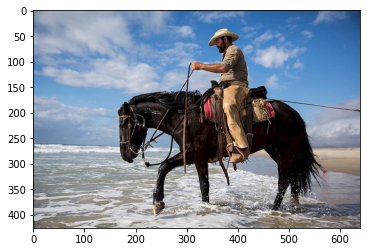

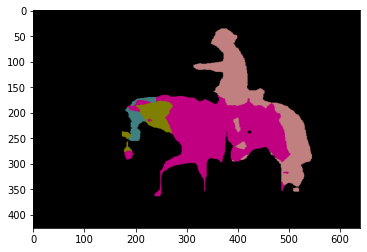

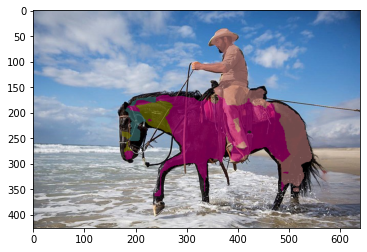

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# 1. 元画像の表示
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)


# 4. PSPNetで推論する
net.eval()
x = img.unsqueeze(0).to(device)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])
 

# 5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y.cpu()
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()


# 6. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()